In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import squidpy as sq
import anndata as ad
import seaborn as sns
import networkx as nx
import pandas as pd

import sys
sys.path.append("../src/")
sys.path.append("/data/bionets/je30bery/truncated_graphs/src/")
from truncated_graphs import *

In [2]:
t = "regular"
n = 400
bounds = (0, 20)
coordinates = generate_coordinates(n=n, bounds=bounds, type=t)
original = create_anndata(coordinates, n_neighs=6, bounds=bounds)
original, truncated = fully_process(adata_original=original, bounds=bounds, borders=[0])

measure = "degree"
d = original.obs["distance_to_border"].values
C = original.obs[measure].values
df = pd.DataFrame(np.array([d, C]).T, columns=["Distance to border", f"{measure.capitalize()} centrality"])

In [14]:
measure = "harmonic"
d = original.obs["distance_to_border"].values
C = original.obs[measure].values

In [15]:
n = len(d) 
M = 1000  # big M für binäre Nebenbedingung

model = gp.Model()

m = model.addVar(vtype=GRB.CONTINUOUS, name="m") # Steigung vor Ellebogen
c0 = model.addVar(vtype=GRB.CONTINUOUS, name="c0") # y-Achsenabschnitt C(0)
b = model.addVar(vtype=GRB.CONTINUOUS, lb=min(d), ub=max(d), name="b") # Ellebogen

z = model.addVars(n, vtype=GRB.BINARY, name="z")

epsilon = model.addVars(n, vtype=GRB.CONTINUOUS, name="epsilon")

model.setObjective(gp.quicksum(epsilon[i] * epsilon[i] for i in range(n)), GRB.MINIMIZE)

for i in range(n):
    # 1. wenn z[i] = 1 (d_i <= b, links von Ellebogen), dann epsilon_i >= m * d_i + c0 - C_i
    model.addConstr(epsilon[i] >= (m * d[i] + c0 - C[i]) - (1 - z[i]) * M)
    model.addConstr(epsilon[i] >= -(m * d[i] + c0 - C[i]) - (1 - z[i]) * M)

    # 2. wenn z[i] = 0 (d_i > b, rechts von Ellebogen), dann epsilon_i >= m * b + c0 - C_i
    model.addConstr(epsilon[i] >= (m * b + c0 - C[i]) - z[i] * M)
    model.addConstr(epsilon[i] >= -(m * b + c0 - C[i]) - z[i] * M)

    # binärer "Switch"
    model.addConstr(z[i] * M >= b - d[i])
    model.addConstr((1 - z[i]) * M >= d[i] - b)

model.optimize()

print(f"m: {m.X}")
print(f"Optimales c0: {c0.X}")
print(f"Optimales b (Ellbogenpunkt): {b.X}")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Gold 6242R CPU @ 3.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 20 physical cores, 40 logical processors, using up to 20 threads

Optimize a model with 1600 rows, 803 columns and 4800 nonzeros
Model fingerprint: 0x7607a70a
Model has 400 quadratic objective terms
Model has 800 quadratic constraints
Variable types: 403 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e-05, 9e+00]
  RHS range        [1e-05, 1e+03]
  QRHS range       [6e-01, 1e+00]
Found heuristic solution: objective 1.600000e+21
Presolve added 720 rows and 2 columns
Presolve time: 0.02s
Presolved: 2324 rows, 806 columns, 7848 nonzeros
Presolved model has 400 quadratic objective terms
Presolved model

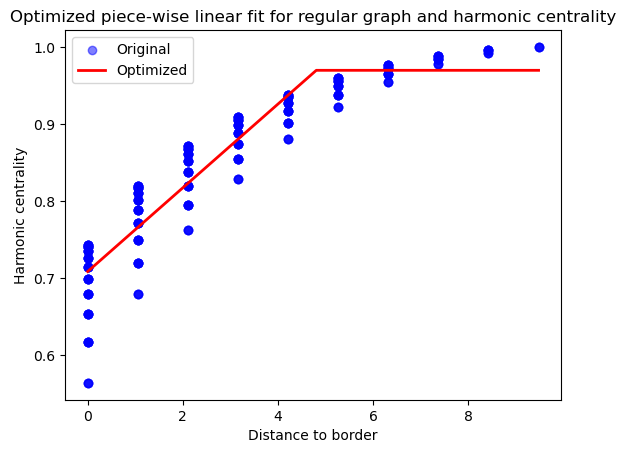

In [16]:
m_opt = m.X
c0_opt = c0.X
b_opt = b.X

d_curve = np.linspace(min(d), max(d), 500)

C_curve = np.piecewise(
    d_curve,
    [d_curve <= b_opt, d_curve > b_opt],
    [lambda x: m_opt * x + c0_opt, lambda x: m_opt * b_opt + c0_opt]
)

plt.scatter(d, C, color="blue", label="Original", alpha=0.5)
plt.plot(d_curve, C_curve, color="red", label="Optimized", linewidth=2)
plt.xlabel("Distance to border")
plt.ylabel(f"{measure.capitalize()} centrality")
plt.title(f"Optimized piece-wise linear fit for {t} graph and {measure} centrality")
plt.legend()
plt.savefig(f"../result_plots/{t}_{measure}_{n}.pdf")